# CNN training on split CNV by 2 classes

In [1]:
import os
import re
import copy
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pandas as pd

import PIL
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn

from __future__ import print_function
#import keras
from tensorflow import keras
import keras.preprocessing
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend

import function_dl as func_dl
import function as func

%load_ext autoreload
%autoreload 2

Tensorflow version 2.2.0
Tensorflow version 2.2.0


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
img_width, img_height = 224, 224
seed = 2021

## Importing data from scratch

### Import file path

In [4]:
## For splited rare deletions
true_del_file  = '/home/rt2776/cnv_espresso/images_rare_3classes/0-split_cnv_file_list/true_del_split_files.list'
false_del_file = '/home/rt2776/cnv_espresso/images_rare_3classes/0-split_cnv_file_list/false_del_split_files.list'

## For splited rare duplications
true_dup_file  = '/home/rt2776/cnv_espresso/images_rare_3classes/0-split_cnv_file_list/true_dup_split_files.list'
false_dup_file = '/home/rt2776/cnv_espresso/images_rare_3classes/0-split_cnv_file_list/false_dup_split_files.list'

In [5]:
## For file with image path only:

true_del_list = [each_file[0] for each_file in func.fileToList(true_del_file)]
false_del_list = [each_file[0] for each_file in func.fileToList(false_del_file)]

true_dup_list = [each_file[0] for each_file in func.fileToList(true_dup_file)]
false_dup_list = [each_file[0] for each_file in func.fileToList(false_dup_file)]

print(len(true_del_list), len(false_del_list))
print(len(true_dup_list), len(false_dup_list))

20687 2273
64918 7982


### Loading images from list to numpy array

In [8]:
# # entire cnv
true_del_img_np = func_dl.loadImgs(true_del_list, img_width, img_height)
true_del_img_np.shape

false_del_img_np = func_dl.loadImgs(false_del_list, img_width, img_height)
false_del_img_np.shape

true_dup_img_np = func_dl.loadImgs(true_dup_list, img_width, img_height)
true_dup_img_np.shape

false_dup_img_np = func_dl.loadImgs(false_dup_list, img_width, img_height)
false_dup_img_np.shape

[2021.02.23-21:48:25] Processing 1 ...
[2021.02.23-21:49:44] Processing 1001 ...
[2021.02.23-21:51:01] Processing 2001 ...
[2021.02.23-21:52:19] Processing 3001 ...
[2021.02.23-21:53:37] Processing 4001 ...
[2021.02.23-21:54:56] Processing 5001 ...
[2021.02.23-21:56:14] Processing 6001 ...
[2021.02.23-21:57:32] Processing 7001 ...
[2021.02.23-21:58:51] Processing 8001 ...
[2021.02.23-22:00:10] Processing 9001 ...
[2021.02.23-22:01:28] Processing 10001 ...
[2021.02.23-22:02:46] Processing 11001 ...
[2021.02.23-22:04:04] Processing 12001 ...
[2021.02.23-22:05:22] Processing 13001 ...
[2021.02.23-22:06:42] Processing 14001 ...
[2021.02.23-22:08:01] Processing 15001 ...
[2021.02.23-22:09:17] Processing 16001 ...
[2021.02.23-22:10:35] Processing 17001 ...
[2021.02.23-22:11:52] Processing 18001 ...
[2021.02.23-22:13:09] Processing 19001 ...
[2021.02.23-22:14:26] Processing 20001 ...
[2021.02.23-22:15:21] Done 20686.
[2021.02.23-22:15:22] Processing 1 ...
[2021.02.23-22:16:39] Processing 1001

(7982, 224, 224, 3)

### Generate labels for entire CNVs

In [9]:
# Two classes
true_del_label = [1 for i in range(0,len(true_del_img_np))]
false_del_label = [0 for i in range(0,len(false_del_img_np))]

true_dup_label = [1 for i in range(0,len(true_dup_img_np))]
false_dup_label = [0 for i in range(0,len(false_dup_img_np))]

In [ ]:
# # Four classes
# true_del_label = [0 for i in range(0,len(true_del_img_np))]
# false_del_label = [1 for i in range(0,len(false_del_img_np))]

# true_dup_label = [3 for i in range(0,len(true_dup_img_np))]
# false_dup_label = [2 for i in range(0,len(false_dup_img_np))]

# print(true_del_label[0:5], false_del_label[0:5], true_dup_label[0:5], false_dup_label[0:5])
# print(len(true_del_label), len(false_del_label), len(true_dup_label), len(false_dup_label))

In [ ]:
# # Three classes
# true_del_label = [0 for i in range(0,len(true_del_img_np))]
# false_del_label = [1 for i in range(0,len(false_del_img_np))]

# true_dup_label = [2 for i in range(0,len(true_dup_img_np))]
# false_dup_label = [1 for i in range(0,len(false_dup_img_np))]

# print(true_del_label[0:5], false_del_label[0:5], true_dup_label[0:5], false_dup_label[0:5])
# print(len(true_del_label), len(false_del_label), len(true_dup_label), len(false_dup_label))

### Combine true & false data

In [10]:
combined_del_img_np = np.vstack((true_del_img_np, false_del_img_np))
combined_dup_img_np = np.vstack((true_dup_img_np, false_dup_img_np))

combined_del_img_np.shape, combined_dup_img_np.shape

((22960, 224, 224, 3), (72900, 224, 224, 3))

In [11]:
combined_del_label = true_del_label + false_del_label
combined_dup_label = true_dup_label + false_dup_label
print(len(combined_del_label), len(combined_dup_label))

22960 72900


## Backup or restore data

In [ ]:
backup_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/'
# os.makedirs(backup_path, exist_ok=True)

- Backup

In [13]:
## Backup

# project_name = 'rare_entire_del'
# combined_cnv_info_df.to_csv(backup_path+'rare_del_entire_cnv_info.csv')
# np.save(backup_path+'rare_del_entire_img', combined_img_np)
# np.save(backup_path+'rare_del_entire_label', combined_label)

# project_name = 'rare_entire_dup'
# combined_cnv_info_df.to_csv(backup_path+'rare_entire_dup_info.csv')
# np.save(backup_path+'rare_entire_dup_img', combined_img_np)
# np.save(backup_path+'rare_entire_dup_label', combined_label)

# project_name = 'rare_entire_cnv'
# combined_cnv_info_df.to_csv(backup_path+'rare_entire_cnv_info.csv')
# np.save(backup_path+'rare_entire_cnv_img', combined_img_np)
# np.save(backup_path+'rare_entire_cnv_label_'+str(len(np.unique(combined_label)))+'classes', combined_label)

project_name = 'rare_split_cnv_2classes'
np.save(backup_path+'rare_split_del_2classes_img', combined_del_img_np)
np.save(backup_path+'rare_split_del_2classes_label', combined_del_label)
np.save(backup_path+'rare_split_dup_2classes_img', combined_dup_img_np)
np.save(backup_path+'rare_split_dup_2classes_label', combined_dup_label)

In [77]:
project_name = 'rare_split_dup_2classes'
project_name = 'rare_split_del_2classes'

- Restore

In [ ]:
## Restore for entire del or dup

# project_name = 'rare_entire_del'
# project_name = 'rare_entire_dup'
# project_name = 'rare_entire_cnv'
# nClasses = 3
# if project_name == 'rare_entire_del' or project_name == 'rare_entire_dup' or project_name == 'rare_entire_cnv':
#     combined_img = np.load(backup_path + project_name + '_img.npy')
#     combined_label = np.load(backup_path+'rare_entire_cnv_label_'+str(nClasses)+'classes'+ '.npy')
#     combined_cnv_info_df = pd.read_csv(backup_path+project_name+'_info.csv')

In [5]:
## Restore for split del or dup

# project_name = 'rare_split_cnv_3classes'
# nClasses = 3

# combined_label  = np.load(backup_path + project_name + '_label.npy')
# combined_img = np.load(backup_path + project_name + '_img_np.npy')

In [10]:
print("Project: '%s' dataset loaded."%project_name)
print("  -- Shape of image array: ", combined_img.shape)
print("  -- Shape of label      : ", combined_label.shape)
try:
    print("  -- Shape of CNV info   : ", combined_cnv_info_df.shape)
except:
    print("There is no CNV info data for split del or dup.")

Project: 'rare_split_cnv_3classes' dataset loaded.
  -- Shape of image array:  (95860, 224, 224, 3)
  -- Shape of label      :  (95860,)
There is no CNV info data for split del or dup.


1

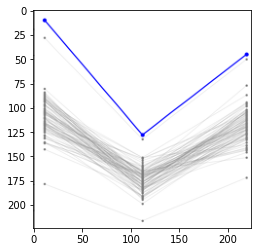

In [15]:
i=2001
func_dl.showImg(combined_dup_img_np[i])
combined_dup_label[i]

1

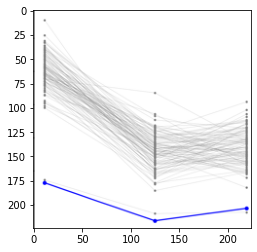

In [79]:
i=2001
func_dl.showImg(combined_del_img_np[i])
combined_del_label[i]

## Normalization

In [16]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = combined_dup_img_np.shape[1:]
input_shape = (nRows, nCols, nDims)
print("The shape of input tensor:",input_shape)

The shape of input tensor: (224, 224, 3)


In [80]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = combined_del_img_np.shape[1:]
input_shape = (nRows, nCols, nDims)
print("The shape of input tensor:",input_shape)

The shape of input tensor: (224, 224, 3)


In [17]:
# Change to float datatype
dup_img = combined_dup_img_np.astype('float32')

# Scale the data to lie between 0 to 1
dup_img /= 255

# Change the labels from integer to categorical data
dup_label_one_hot = to_categorical(combined_dup_label)

In [81]:
# Change to float datatype
del_img = combined_del_img_np.astype('float32')

# Scale the data to lie between 0 to 1
del_img /= 255

# Change the labels from integer to categorical data
del_label_one_hot = to_categorical(combined_del_label)

## Find the unique numbers from the train labels

In [20]:
classes = np.unique(combined_dup_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
print("4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")
print("2 classes label: 0-True del; 1-False del; 0-False dup; 1-True dup")

Total number of outputs :  2
Output classes :  [0 1]
4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup
2 classes label: 0-True del; 1-False del; 0-False dup; 1-True dup


In [82]:
classes = np.unique(combined_del_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
print("4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")
print("2 classes label: 0-True del; 1-False del; 0-False dup; 1-True dup")

Total number of outputs :  2
Output classes :  [0 1]
4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup
2 classes label: 0-True del; 1-False del; 0-False dup; 1-True dup


In [83]:
np.unique(combined_dup_label)

array([0, 1])

In [84]:
np.unique(combined_del_label)

array([0, 1])

0
[[0.9529412 0.9529412 0.9529412]
 [0.5647059 0.5647059 0.5647059]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]]


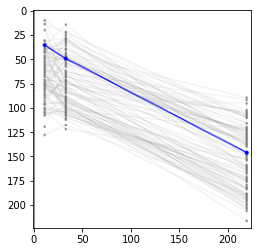

In [51]:
item = random.randint(0,len(combined_dup_label))
print(combined_dup_label[item])
func_dl.showImg(dup_img[item])
print(dup_img[item][100][0:10])

1
[[0.9529412 0.9529412 0.9529412]
 [0.5647059 0.5647059 0.5647059]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]
 [1.        1.        1.       ]]


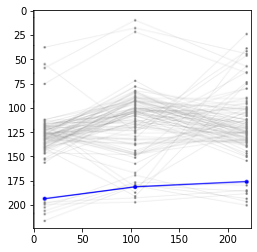

In [99]:
item = random.randint(0,len(combined_del_label))
print(combined_del_label[item])
func_dl.showImg(del_img[item])
print(del_img[item][100][0:10])

In [101]:
del_img.shape, len(combined_del_label)

((22960, 224, 224, 3), 22960)

## Train the deep nerual model by Hold-out validation
- Ref: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
### Split dataset into training(80%) and testing(20%) dataset

In [102]:
## split image arrays
train_img, test_img, train_label, test_label = train_test_split(del_img,
                                                                del_label_one_hot,
                                                                test_size=0.2,
                                                                shuffle=True,
                                                                random_state=seed)

train_img, val_img, train_label, val_label = train_test_split(train_img,
                                                              train_label,
                                                              test_size=0.25,
                                                              shuffle=True,
                                                              random_state=seed) # 0.25*0.8=0.2

del_img.shape, train_img.shape, val_img.shape, test_img.shape
del_label_one_hot.shape, train_label.shape, val_label.shape, test_label.shape

((22960, 2), (13776, 2), (4592, 2), (4592, 2))

Label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


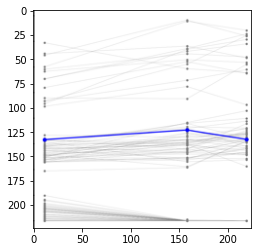

In [60]:
i=random.randrange(len(train_img))
## if the the images are different, then it means it has been shuffled.
print("Label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")
func_dl.showImg(train_img[i]),train_label[i]#,train_cnv_info_df.iloc[i,:],train_cnv_info_df.iloc[i,20]
print(train_img[i][100][80:100])

In [103]:
test_img.shape, test_label.shape

((4592, 224, 224, 3), (4592, 2))

In [110]:
print(len(test_label[np.where(test_label==[0,1])]))
print(len(test_label[np.where(test_label==[1,0])]))

8256
928


### MobileNet v1. transfer learning and fine tuning
- Firstly, we keep all the weights of base model frozen to train the fc layers.

In [111]:
model_dir = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/'

In [112]:
nClasses

2

In [113]:
model_name='MobileNet_v1_fine-tuning'
base_model = tf.keras.applications.MobileNet(
weights='imagenet',  # Load weights pre-trained model.
input_shape=(224, 224, 3),    #input_shape=(224, 224, 3),
include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3)) #keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nClasses,activation='softmax')(x)      
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 2,050
Non-trainable params: 3,228,864
_________________________________________________________________


In [114]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', func_dl.f1_m, func_dl.precision_m, func_dl.recall_m])

In [115]:
print("Training by MobileNet_v1 model ...")
batch_size = 32
epochs = 20
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
print("\n")
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

Training by MobileNet_v1 model ...
Epoch 1/20
431/431 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 0.9014 - f1_m: 0.9015 - precision_m: 0.9015 - recall_m: 0.9015
Epoch 00001: val_accuracy improved from -inf to 0.91006, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_split_cnv_2classes_MobileNet_v1_fine-tuning_2classes.h5
431/431 [==============================] - 272s 631ms/step - loss: 0.2357 - accuracy: 0.9014 - f1_m: 0.9015 - precision_m: 0.9015 - recall_m: 0.9015 - val_loss: 0.1989 - val_accuracy: 0.9101 - val_f1_m: 0.9102 - val_precision_m: 0.9102 - val_recall_m: 0.9102
Epoch 2/20
431/431 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9125 - f1_m: 0.9126 - precision_m: 0.9126 - recall_m: 0.9126
Epoch 00002: val_accuracy did not improve from 0.91006
431/431 [==============================] - 25s 57ms/step - loss: 0.2004 - accuracy: 0.9125 - f1_m: 0.9126 - precision_m: 0.9126 - recall_m: 0.912

Epoch 00016: early stopping


144/144 [==============================] - 5s 34ms/step - loss: 0.1913 - accuracy: 0.9170 - f1_m: 0.9171 - precision_m: 0.9171 - recall_m: 0.9171



--- Confusion matrix for test data ---

2 classes label: 1-True; 0-False


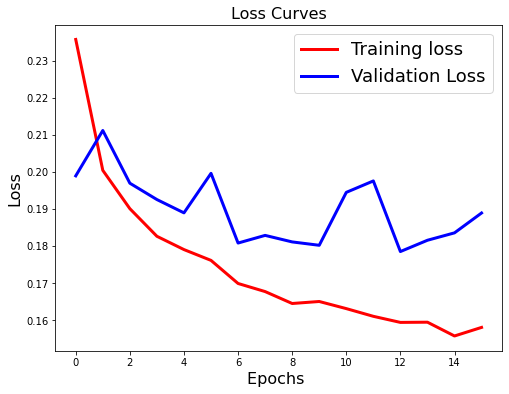

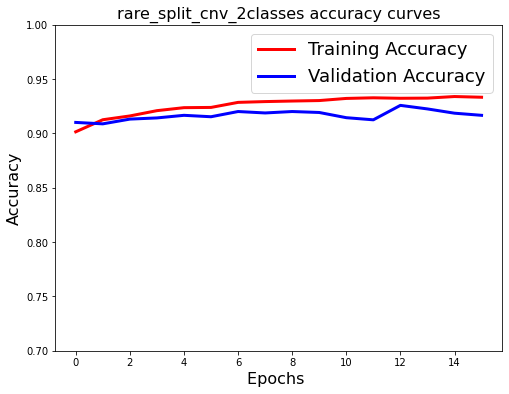

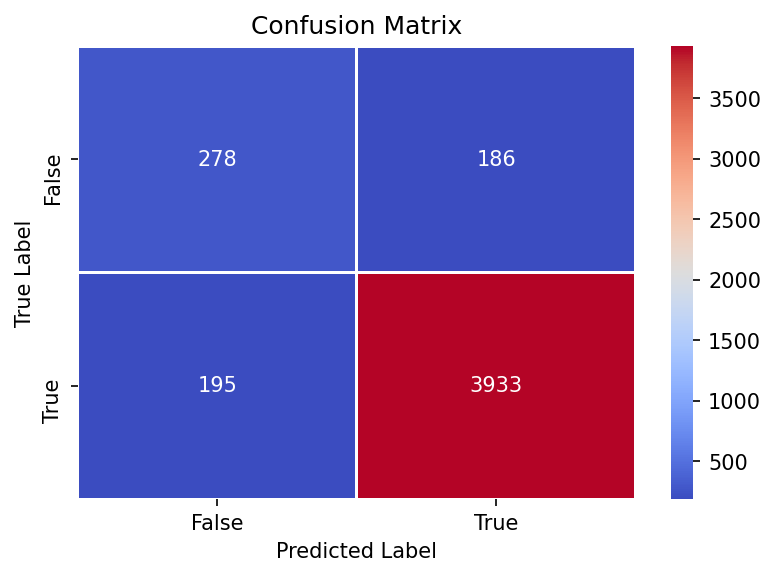


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.59      0.60      0.59       464
           1       0.95      0.95      0.95      4128

    accuracy                           0.92      4592
   macro avg       0.77      0.78      0.77      4592
weighted avg       0.92      0.92      0.92      4592



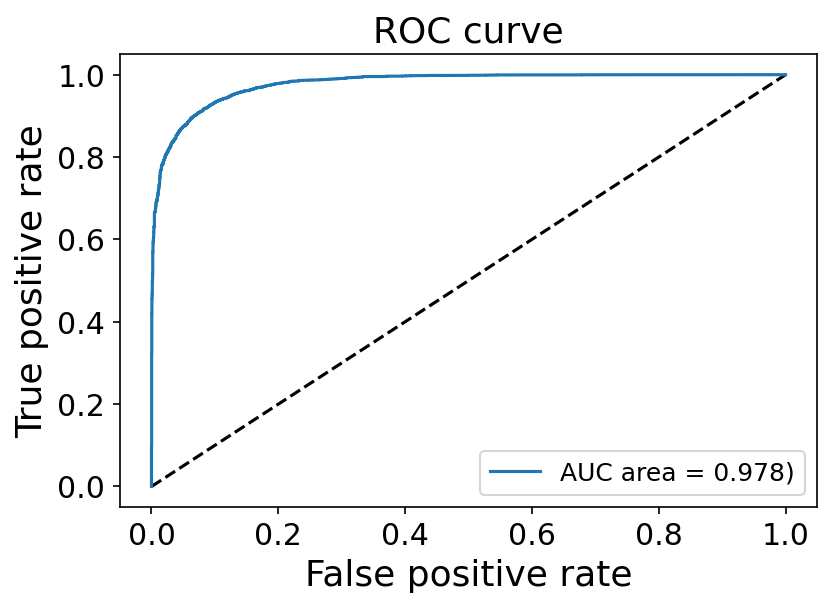

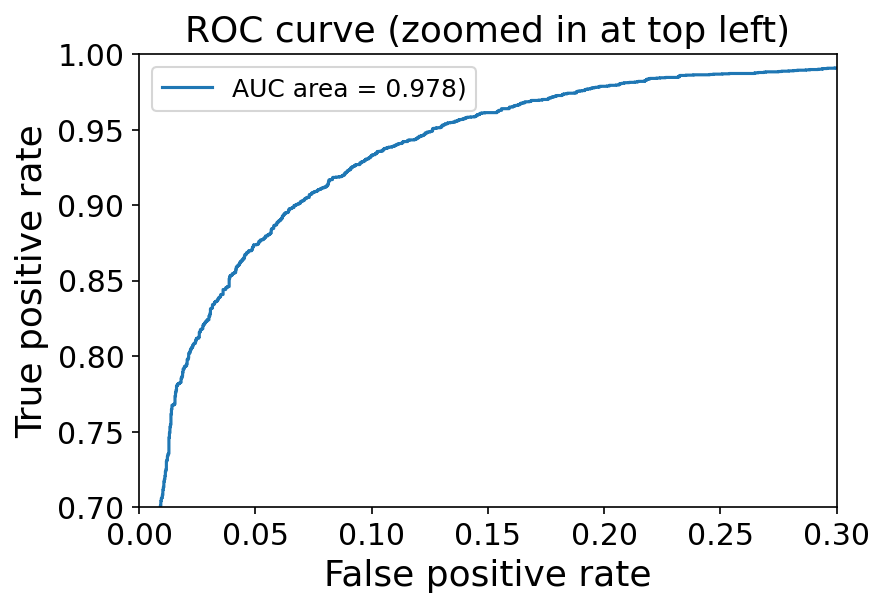

In [116]:
func_dl.draw_loss_accuracy_curves(history, project_name)
func_dl.confusion_matrix(model, test_img, test_label, nClasses)
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label)
func_dl.draw_single_roc_curve(tpr, fpr, auc)

- Secondly, Once your model has converged on our train data, we unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate.

In [117]:
print("Fine tuning by MobileNet_v1 model ...")
batch_size = 32
epochs = 10
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

base_model.trainable=True
model.summary()

Fine tuning by MobileNet_v1 model ...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [118]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy', metrics=['accuracy', func_dl.f1_m, func_dl.precision_m, func_dl.recall_m])

In [119]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
print("\n")
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

Epoch 1/10
431/431 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9212 - f1_m: 0.9212 - precision_m: 0.9212 - recall_m: 0.9212
Epoch 00001: val_accuracy improved from -inf to 0.91855, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_split_cnv_2classes_MobileNet_v1_fine-tuning_2classes.h5
431/431 [==============================] - 518s 1s/step - loss: 0.1844 - accuracy: 0.9212 - f1_m: 0.9212 - precision_m: 0.9212 - recall_m: 0.9212 - val_loss: 0.1974 - val_accuracy: 0.9186 - val_f1_m: 0.9186 - val_precision_m: 0.9186 - val_recall_m: 0.9186
Epoch 2/10
431/431 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9384 - f1_m: 0.9384 - precision_m: 0.9384 - recall_m: 0.9384
Epoch 00002: val_accuracy improved from 0.91855 to 0.92291, saving model to /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_split_cnv_2classes_MobileNet_v1_fine-tuning_2classes.h5
431/431 [========================


--- Confusion matrix for test data ---

2 classes label: 1-True; 0-False


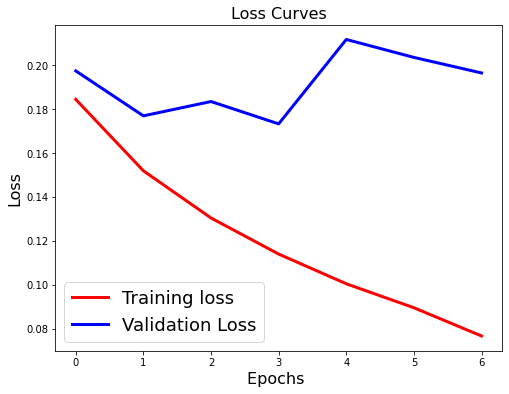

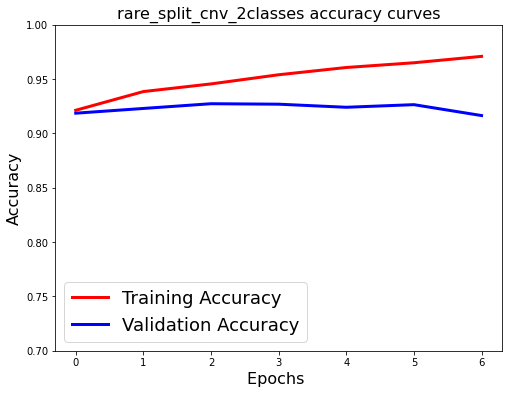

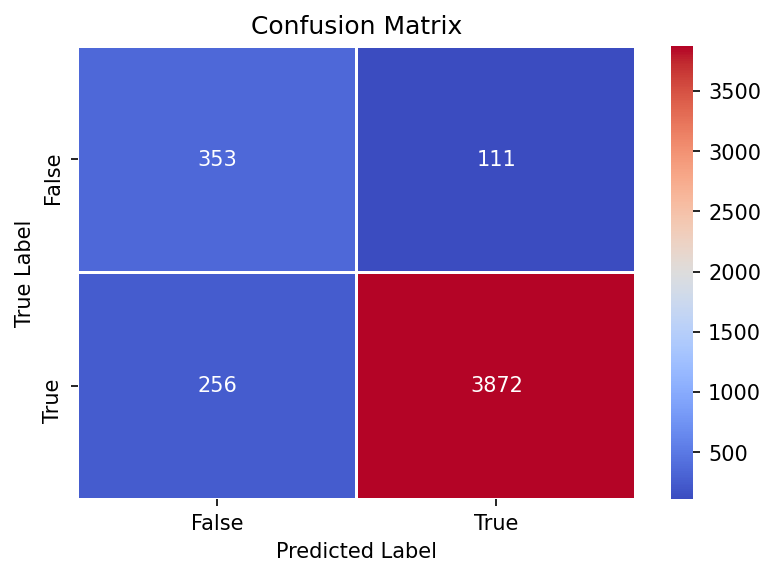


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.58      0.76      0.66       464
           1       0.97      0.94      0.95      4128

    accuracy                           0.92      4592
   macro avg       0.78      0.85      0.81      4592
weighted avg       0.93      0.92      0.92      4592



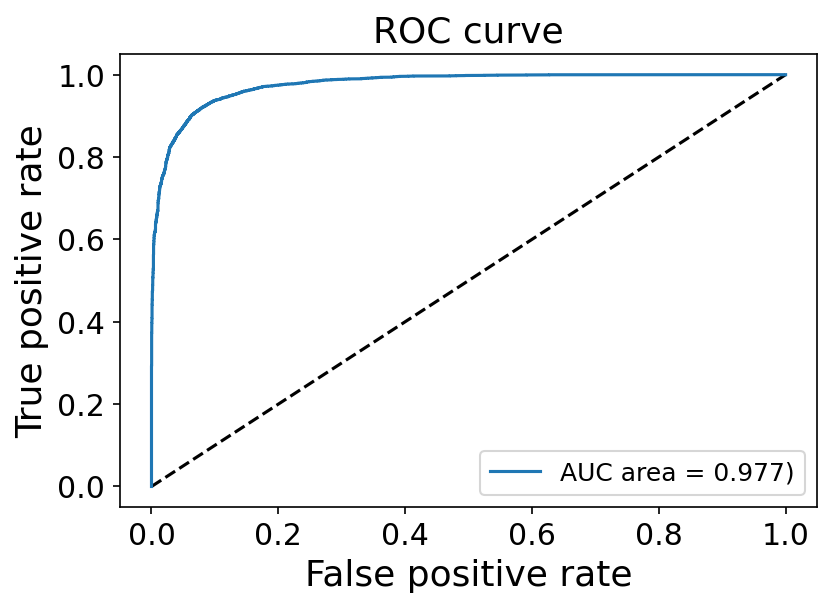

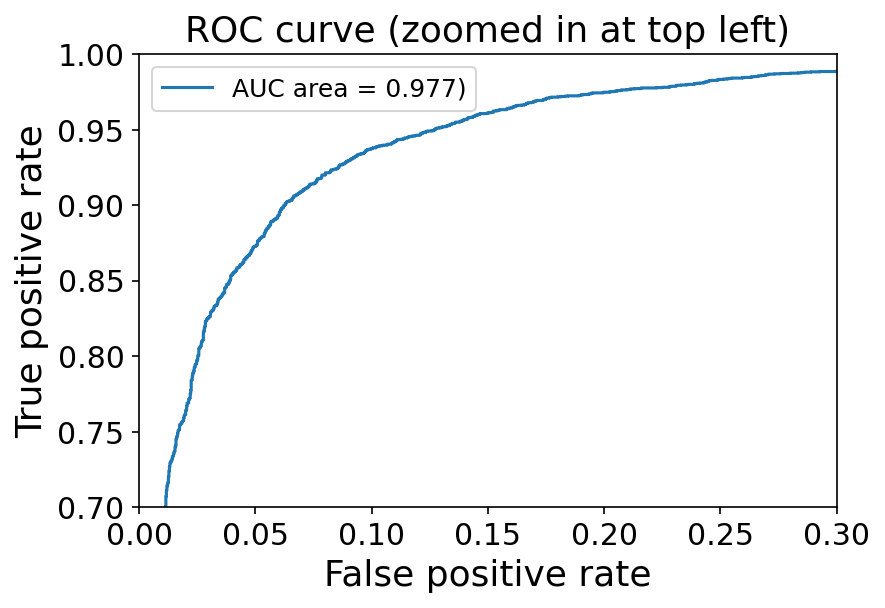

In [120]:
func_dl.draw_loss_accuracy_curves(history, project_name)
func_dl.confusion_matrix(model, test_img, test_label, nClasses)
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label)
func_dl.draw_single_roc_curve(tpr, fpr, auc)

## Result analysis
### Check the predict performance in different target numbers categories

In [ ]:
min_win = 3
max_win = 4
selected_test_df, selected_test_img, selected_test_label = func_dl.fetch_df_by_wins(test_cnv_info_df, test_img, test_label, min_win, max_win)

index                                                                      21068
Unnamed: 0                                                                 21068
CHR                                                                            1
PRED_START                                                              46609654
PRED_END                                                                46615076
TYPE                                                                         DUP
SAMPLE                                                                 SP0121823
CANOES_RT                                                                      0
CLAMMS_RT                                                                      0
XHMM_RT                                                                        1
NUM_OVERLAPS_RT                                                                1
RD_PROP_RT                                                                  3.85
GC                          

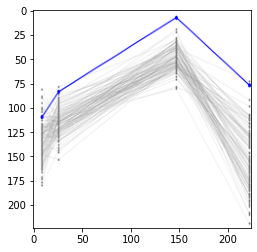

In [172]:
print(selected_test_df.iloc[0,:])
print(selected_test_label[0])
func_dl.showImg(selected_test_img[0])

In [177]:
model_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_fine-tuning_3classes.h5'
custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}
model = keras.models.load_model(model_path, custom_objects=custom_objects)

loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

138/138 [==============================] - 6s 41ms/step - loss: 0.2477 - accuracy: 0.9098 - f1_m: 0.9095 - precision_m: 0.9103 - recall_m: 0.9087


In [272]:
fpr_list, tpr_list, auc_list, info_list = [],[],[],[]

for win_num in range(2,11):
    min_win = win_num
    max_win = win_num
    fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label,
                                                          min_win, max_win)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)
    info_list.append(roc_info)

Tensorflow version 2.2.0
Processing num_windows: 2-2 ...
There is/are 11 CNVs with number of targets/windows between 2 and 2.
Processing num_windows: 3-3 ...
There is/are 202 CNVs with number of targets/windows between 3 and 3.
Processing num_windows: 4-4 ...
There is/are 700 CNVs with number of targets/windows between 4 and 4.
Processing num_windows: 5-5 ...
There is/are 667 CNVs with number of targets/windows between 5 and 5.
Processing num_windows: 6-6 ...
There is/are 457 CNVs with number of targets/windows between 6 and 6.
Processing num_windows: 7-7 ...
There is/are 296 CNVs with number of targets/windows between 7 and 7.
Processing num_windows: 8-8 ...
There is/are 215 CNVs with number of targets/windows between 8 and 8.
Processing num_windows: 9-9 ...
There is/are 188 CNVs with number of targets/windows between 9 and 9.
Processing num_windows: 10-10 ...
There is/are 179 CNVs with number of targets/windows between 10 and 10.


In [274]:
fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label,
                                                          min_win=11, max_win=15)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label,
                                                          min_win=16, max_win=20)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label,
                                                          min_win=21, max_win=50)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label,
                                                          min_win=51, max_win=100)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_cnv_info_df, test_img, test_label,
                                                          min_win=101, max_win=600)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

Processing num_windows: 11-15 ...
There is/are 515 CNVs with number of targets/windows between 11 and 15.
Processing num_windows: 16-20 ...
There is/are 305 CNVs with number of targets/windows between 16 and 20.
Processing num_windows: 21-50 ...
There is/are 505 CNVs with number of targets/windows between 21 and 50.
Processing num_windows: 51-100 ...
There is/are 112 CNVs with number of targets/windows between 51 and 100.
Processing num_windows: 101-600 ...
There is/are 50 CNVs with number of targets/windows between 101 and 600.


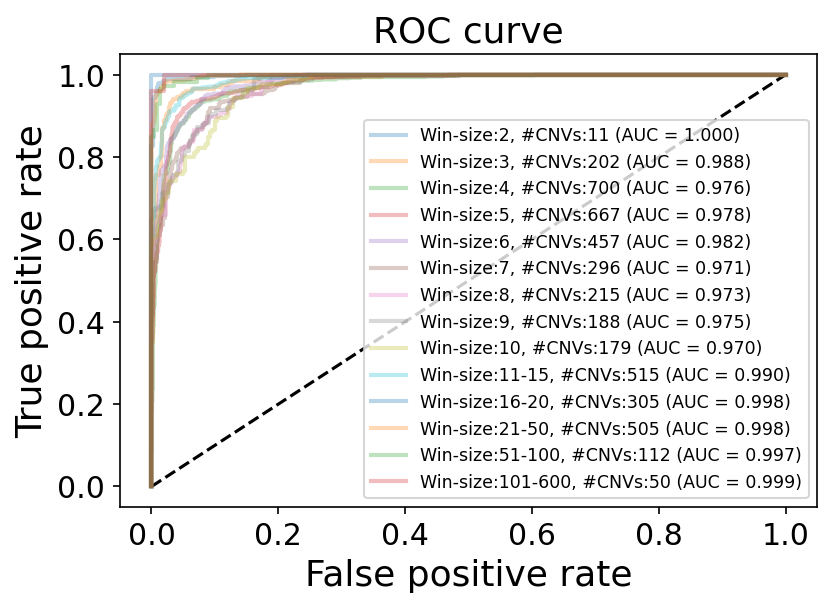

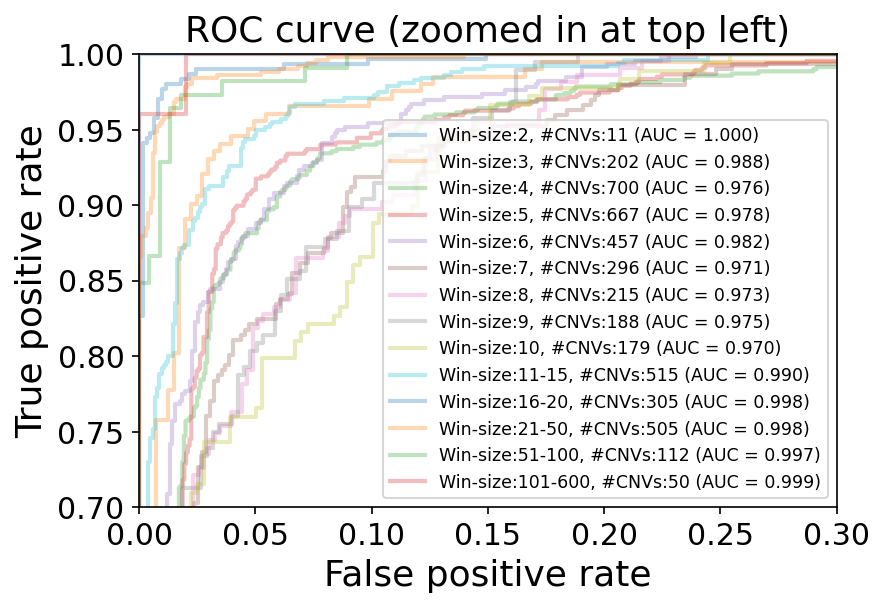

In [275]:
func_dl.draw_multiple_roc_curve(tpr_list, fpr_list, auc_list, info_list, output_image_file=None)

###  Check the prediction performace by del and dup seperately

In [250]:
#test_cnv_info_df = test_cnv_info_df.reset_index()

In [282]:
test_del_index = test_cnv_info_df[test_cnv_info_df["TYPE"]=='DEL'].index
test_del_cnv_info_df = test_cnv_info_df.iloc[test_del_index]
test_del_img = test_img[test_del_index]
test_del_label = test_label[test_del_index]

In [251]:
test_dup_index = test_cnv_info_df[test_cnv_info_df["TYPE"]=='DUP'].index
test_dup_cnv_info_df = test_cnv_info_df.iloc[test_dup_index]
test_dup_img = test_img[test_dup_index]
test_dup_label = test_label[test_dup_index]

In [283]:
test_dup_cnv_info_df.shape, test_del_cnv_info_df.shape

Tensorflow version 2.2.0


((3155, 24), (1247, 24))

- Deletion

In [284]:
fpr_list, tpr_list, auc_list, info_list = [],[],[],[]

for win_num in range(2,11):
    min_win = win_num
    max_win = win_num
    fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win, max_win)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)
    info_list.append(roc_info)
    
fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win=11, max_win=15)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win=16, max_win=20)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win=21, max_win=50)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win=51, max_win=100)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_del_cnv_info_df, test_del_img, test_del_label,
                                                          min_win=101, max_win=600)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

func_dl.draw_multiple_roc_curve(tpr_list, fpr_list, auc_list, info_list, output_image_file=None)

Processing num_windows: 2-2 ...
There is/are 2 CNVs with number of targets/windows between 2 and 2.
Processing num_windows: 3-3 ...
There is/are 101 CNVs with number of targets/windows between 3 and 3.
Processing num_windows: 4-4 ...
There is/are 149 CNVs with number of targets/windows between 4 and 4.
Processing num_windows: 5-5 ...
There is/are 176 CNVs with number of targets/windows between 5 and 5.
Processing num_windows: 6-6 ...
There is/are 148 CNVs with number of targets/windows between 6 and 6.
Processing num_windows: 7-7 ...
There is/are 92 CNVs with number of targets/windows between 7 and 7.
Processing num_windows: 8-8 ...
There is/are 65 CNVs with number of targets/windows between 8 and 8.
Processing num_windows: 9-9 ...
There is/are 61 CNVs with number of targets/windows between 9 and 9.
Processing num_windows: 10-10 ...
There is/are 60 CNVs with number of targets/windows between 10 and 10.
Processing num_windows: 11-15 ...
There is/are 141 CNVs with number of targets/windo

- Duplication

Processing num_windows: 2-2 ...
There is/are 9 CNVs with number of targets/windows between 2 and 2.
Processing num_windows: 3-3 ...
There is/are 101 CNVs with number of targets/windows between 3 and 3.
Processing num_windows: 4-4 ...
There is/are 551 CNVs with number of targets/windows between 4 and 4.
Processing num_windows: 5-5 ...
There is/are 491 CNVs with number of targets/windows between 5 and 5.
Processing num_windows: 6-6 ...
There is/are 309 CNVs with number of targets/windows between 6 and 6.
Processing num_windows: 7-7 ...
There is/are 204 CNVs with number of targets/windows between 7 and 7.
Processing num_windows: 8-8 ...
There is/are 150 CNVs with number of targets/windows between 8 and 8.
Processing num_windows: 9-9 ...
There is/are 127 CNVs with number of targets/windows between 9 and 9.
Processing num_windows: 10-10 ...
There is/are 119 CNVs with number of targets/windows between 10 and 10.
Processing num_windows: 11-15 ...
There is/are 374 CNVs with number of targets/w

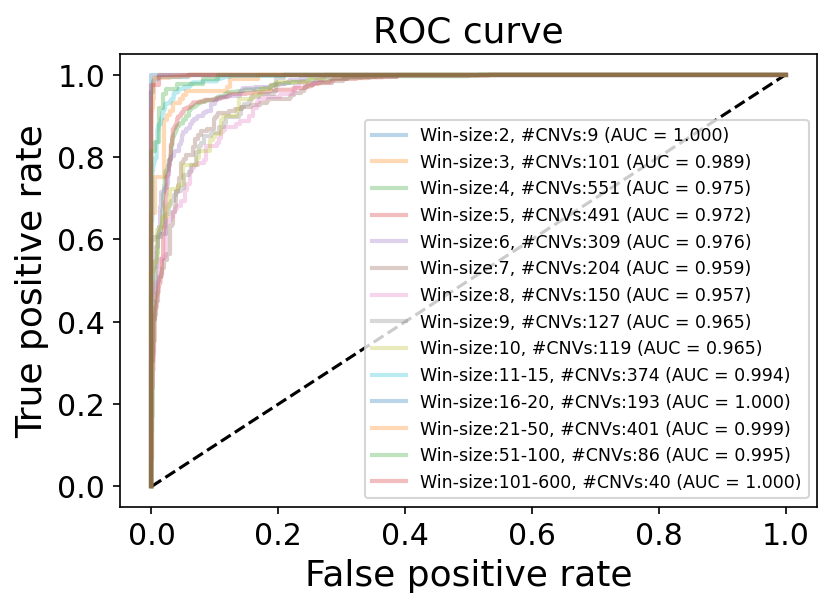

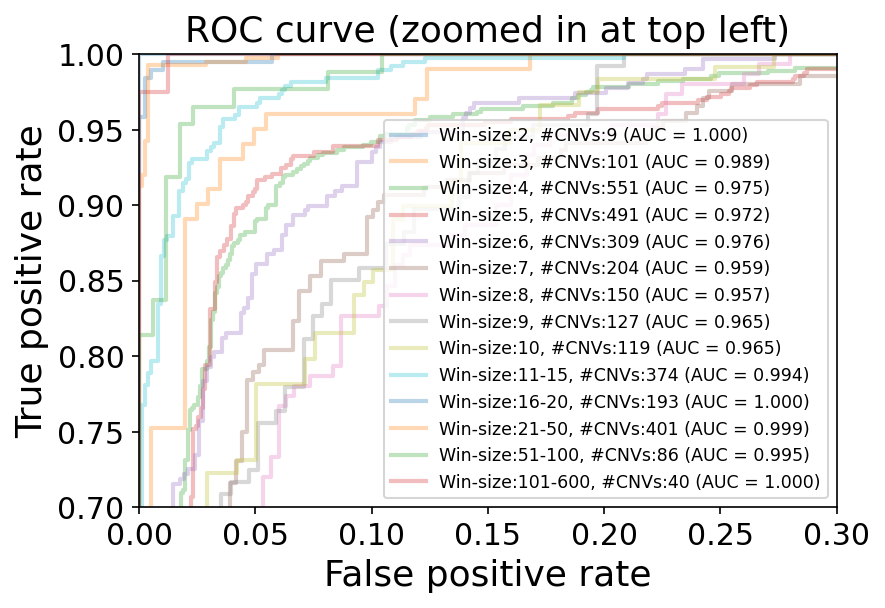

In [286]:
fpr_list, tpr_list, auc_list, info_list = [],[],[],[]

for win_num in range(2,11):
    min_win = win_num
    max_win = win_num
    fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win, max_win)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)
    info_list.append(roc_info)
    
fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win=11, max_win=15)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win=16, max_win=20)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win=21, max_win=50)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win=51, max_win=100)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

fpr, tpr, auc, roc_info = func_dl.fetch_roc_info_by_num_win(model, test_dup_cnv_info_df, test_dup_img, test_dup_label,
                                                          min_win=101, max_win=600)
fpr_list.append(fpr)
tpr_list.append(tpr)
auc_list.append(auc)
info_list.append(roc_info)

func_dl.draw_multiple_roc_curve(tpr_list, fpr_list, auc_list, info_list, output_image_file=None)

### Predict the same test data by split CNV trained model

In [287]:
split_model_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_split_cnv_3classes_MobileNet_v1_3classes_fold3.h5'
custom_objects = {"f1_m":func_dl.f1_m, "precision_m":func_dl.precision_m, "recall_m":func_dl.recall_m}
split_model = keras.models.load_model(split_model_path, custom_objects=custom_objects)

In [289]:
split_model.evaluate(test_img, test_label)

138/138 [==============================] - 5s 38ms/step - loss: 0.4433 - accuracy: 0.7924 - f1_m: 0.7927 - precision_m: 0.7941 - recall_m: 0.7913


[0.44326913356781006,
 0.7923671007156372,
 0.7926908731460571,
 0.7941120266914368,
 0.7913143634796143]

In [293]:
combined_cnv_info_df = combined_cnv_info_df.reset_index(drop=True)
combined_cnv_info_df[combined_cnv_info_df["Num_Targets_Wins"]==3]

,Unnamed: 0,CHR,PRED_START,PRED_END,TYPE,SAMPLE,CANOES_RT,CLAMMS_RT,XHMM_RT,NUM_OVERLAPS_RT,...,PRED_SIZE,MAP,NUM_TARGETS,SIZE_LABEL,LABEL_VAL,ref,batch,Num_Carriers(inGivenCohort),Num_Targets_Wins,image_path
36,36,6,32222510,32223928,DEL,SP0003185,1.0,1.0,1.0,3,...,1418,1.00,3,B)1KB-5KB,1,hg38,spark1,1,3,/home/rt2776/cnv_espresso/images_rare_3classes...
63,63,11,113689764,113690939,DEL,SP0004144,0.0,1.0,1.0,2,...,1175,1.00,3,B)1KB-5KB,1,hg38,spark1,16,3,/home/rt2776/cnv_espresso/images_rare_3classes...
75,75,17,39151361,39156942,DEL,SP0004412,1.0,0.0,0.0,1,...,5581,0.99,3,C)5KB-10KB,1,hg38,spark2,1,3,/home/rt2776/cnv_espresso/images_rare_3classes...
76,76,1,12774867,12777599,DEL,SP0004477,1.0,1.0,1.0,3,...,2732,1.00,3,B)1KB-5KB,1,hg38,spark1,1,3,/home/rt2776/cnv_espresso/images_rare_3classes...
85,85,20,63373880,63377904,DEL,SP0004698,1.0,1.0,1.0,3,...,4024,1.00,3,B)1KB-5KB,1,hg38,spark1,8,3,/home/rt2776/cnv_espresso/images_rare_3classes...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,21995,19,14583356,14592358,DUP,SP0150012,0.0,0.0,1.0,1,...,9002,0.88,3,C)5KB-10KB,0,hg38,spark10,5,3,/home/rt2776/cnv_espresso/images_rare_3classes...
21996,21996,1,27382499,27382667,DUP,SP0150060,0.0,0.0,1.0,1,...,168,1.00,3,A)<1KB,0,hg38,spark10,2,3,/home/rt2776/cnv_espresso/images_rare_3classes...
22002,22002,12,80652743,80669141,DUP,SP0151577,0.0,0.0,1.0,1,...,16398,1.00,3,D)10KB-25KB,0,hg38,spark10,5,3,/home/rt2776/cnv_espresso/images_rare_3classes...
22005,22005,3,195739846,195749064,DUP,SP0154149,0.0,0.0,1.0,1,...,9218,0.99,3,C)5KB-10KB,0,hg38,spark10,80,3,/home/rt2776/cnv_espresso/images_rare_3classes...


       Unnamed: 0  CHR  PRED_START   PRED_END TYPE     SAMPLE  CANOES_RT  \
36             36    6    32222510   32223928  DEL  SP0003185        1.0   
63             63   11   113689764  113690939  DEL  SP0004144        0.0   
75             75   17    39151361   39156942  DEL  SP0004412        1.0   
76             76    1    12774867   12777599  DEL  SP0004477        1.0   
85             85   20    63373880   63377904  DEL  SP0004698        1.0   
...           ...  ...         ...        ...  ...        ...        ...   
21995       21995   19    14583356   14592358  DUP  SP0150012        0.0   
21996       21996    1    27382499   27382667  DUP  SP0150060        0.0   
22002       22002   12    80652743   80669141  DUP  SP0151577        0.0   
22005       22005    3   195739846  195749064  DUP  SP0154149        0.0   
22007       22007   12   132604705  132606251  DUP  SP0154427        0.0   

       CLAMMS_RT  XHMM_RT  NUM_OVERLAPS_RT  ...  PRED_SIZE   MAP  NUM_TARGETS  \
36    

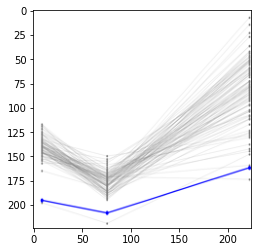

In [294]:
#selected_index = combined_cnv_info_df.sample(n=2000, random_state=61).index
selected_index = combined_cnv_info_df[combined_cnv_info_df["Num_Targets_Wins"]==3].index
select_df = combined_cnv_info_df.iloc[selected_index]
select_img = combined_img[selected_index]
select_label = combined_label[selected_index]
select_label_one_hot = combined_label_one_hot[selected_index]
print(select_df)
print(select_label)
print(select_label_one_hot)
func_dl.showImg(select_img[0])

In [297]:
split_model.evaluate(select_img, select_label_one_hot)

31/31 [==============================] - 1s 32ms/step - loss: 0.0981 - accuracy: 0.9720 - f1_m: 0.9733 - precision_m: 0.9738 - recall_m: 0.9728


[0.09807594865560532,
 0.9720207452774048,
 0.9732623100280762,
 0.9737578630447388,
 0.9727822542190552]

In [270]:
#fpr_roc, tpr_roc, thresholds_roc, auc_roc 
func_dl.pred_roc_data(model, select_img, select_label_one_hot)

(array([0.    , 0.    , 0.    , ..., 0.852 , 0.9995, 1.    ]),
 array([0.   , 0.142, 0.146, ..., 1.   , 1.   , 1.   ]),
 array([1.9999976e+00, 9.9999762e-01, 9.9999750e-01, ..., 6.0904695e-20,
        6.0904223e-20, 6.0903990e-20], dtype=float32),
 0.9903235625)

### Performance on PCGC experimental results

In [4]:
pcgc_prediction_file = '/home/rt2776/cnv_espresso/predict_pcgc/pcgc_NimbleGenV2_data_prediction_0223.csv'
pcgc_prediction_df = pd.read_csv(pcgc_prediction_file)
pcgc_prediction_df

,ID,Chr,Start,End,Band,CNV_TYPE,Syndrome_or_Gene,AnalysisObserved†,CardiacLesion(Diagnosis),ParentOrigin,...,Size_kb,ref,batch,Num_Targets_Wins,entire_cnv_path,split_cnv_path,Prob_True,Prob_False,Prediction,Pred_status
0,1-01401,1,59247993,59251097,p32.1,1,JUN,A,LVOT(HLHS),-,...,3.1,hg19,NimbleGenV2,1,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,NaN,NaN,NaN,NaN
1,1-03171,1,145586403,145799634,q21.1,3,"1q21.1,dup_or_GJA5‡","A,E",CTD(TOF_or_APVS),-,...,213.2,hg19,NimbleGenV2,50,/home/rt2776/cnv_espresso/predict_pcgc/images_...,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,NaN,NaN,NaN
2,1-01036,1,146631133,147416212,q21.1,3,"1q21.1,dup_or_GJA5‡",E,CTD(TOF),M,...,785.1,hg19,NimbleGenV2,75,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,NaN,NaN,NaN,NaN
3,1-01486,1,194201171,194304070,q24.2–q25,3,CDC73,A,LVOT(HLHS),-,...,102.9,hg19,NimbleGenV2,0,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,NaN,NaN,NaN,NaN
4,1-01536,2,70168995,70359345,p13.3,1,PCBP1,A,CTD(TOF_or_PA),-,...,190.4,hg19,NimbleGenV2,4,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,NaN,NaN,NaN,NaN
5,1-01401,2,102493466,103001458,q11.2–q12.1,1,MAP4K4,E,LVOT(HLHS),-,...,508.0,hg19,NimbleGenV2,52,/home/rt2776/cnv_espresso/predict_pcgc/images_...,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,NaN,NaN,NaN
6,1-01401,2,145155868,145274931,q22.3,1,Mowat-Wilson_or_ZEB2‡,E,LVOT(HLHS),-,...,119.1,hg19,NimbleGenV2,9,/home/rt2776/cnv_espresso/predict_pcgc/images_...,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,NaN,NaN,NaN
7,1-00762,3,60661,11712230,p26.1,3,"ARL8B,ARPC4,CAMK1,CAV3,CRBN,EMC3,ITPR1,SEC13,S...",A,ASD_or_PS(ASD),-,...,11651.6,hg19,NimbleGenV2,664,/home/rt2776/cnv_espresso/predict_pcgc/images_...,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,NaN,NaN,NaN
8,1-01049,3,15637812,15643461,p25.1,3,"BTD,HACL1",E,CTD(TOF),-,...,5.6,hg19,NimbleGenV2,4,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,NaN,NaN,NaN,NaN
9,1-01045,3,47780965,48309270,p21.31,3,"CDC25A,DHX30,MAP4,SMARCC1",A,LVOT(HLHS),-,...,528.3,hg19,NimbleGenV2,69,/home/rt2776/cnv_espresso/predict_pcgc/images_...,NaN,NaN,NaN,NaN,NaN


## Reference:
- Load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- Transfer learning and toy demo: https://zhuanlan.zhihu.com/p/51889181
- Transfer learning and fine tune: 
    - 讲解：https://zhuanlan.zhihu.com/p/26693647
    - 官方教程：https://www.geek-book.com/src/docs/keras/keras/keras.io/guides/transfer_learning/index.html
- K-fold validation: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
- ROC curve: https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
- F1 score: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model